In [ ]:
!pip install tensorflow -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Import the classic librairies 
  * Tensorflow 2.0
  * Numpy 
  * Matplotlib

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
tf.__version__

'2.8.2'

In [ ]:
import pathlib
data_set_path = pathlib.Path("/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set")
print(data_set_path)

/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set


In [ ]:
#training_data = Path(data_set_path+'/training_set/') 
#validation_data = Path(data_set_path+'/validation_set/')
#bad_images_dir = "bad_images"

In [ ]:
for item in data_set_path.iterdir():
  print(item)

/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set/iconography
/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set/drawings
/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set/engraving
/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set/painting
/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set/sculpture


# Preprocessing with ImageDataGenerator

We will now proceed to the preprocessing of our data. The easiest way to do so is using an `ImageDataGenerator`, that is a very straight forward way to load and preprocess image data for training deep learning models.

1. Instanciate an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator"> ImageDataGenerator </a> with the parameters of your choice, we can adapt them later as we visualize the images and assess the difficulty of the problem.

In [ ]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.2)

2. Prepare two objects `img_generator_flow_train` and `img_generator_flow_valid` thanks to the method `flow_from_directory`. Why is this method well suited to our usecase?
Use a `target_size` of `(224,224)` and the rest is up to your appreciation.

In [ ]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set",
    target_size=(224, 224),
    batch_size=128,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated/global_set",
    target_size=(224, 224),
    batch_size=128,
    shuffle=True,
    subset="validation")

Found 6872 images belonging to 5 classes.
Found 1715 images belonging to 5 classes.


3. Visualize a batch of images coming from the train set. Do you notice anyhting we will have to take into consideration when building the model?

In [ ]:
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  plt.imshow(img)
  plt.title(label)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

1. Import a pretrained model from tensorflow, the solution will use the example of MobileNet, but feel free to use different architecture if you would like to get a different point of view. Make sure you use the pretrained weights frome `imagenet`.

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
#base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

2. Set the weights of your imported model as non-trainable.
Now we have to freeze our model so that only the custom layers will train.

In [ ]:
base_model.trainable = False

3. Create now your complete model by adding the last layer adapted to your situation 

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [ ]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

4. Compile your model with [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) using Adam with a learning rate of `0.001` and the appropriate loss and metrics. 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


5. Train your model and monitor the overfitting using the validation data. Use 20 steps per epochs and 50 epochs in order to monitor the process precisely.

In [ ]:
# steps_per_epoch=4 because proportional to validation_set per batch_size=32
# validation_set = 143 images
# batch_size=32
# 143/32 = 4 

In [ ]:
#model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=20)

Epoch 1/20
47/47 [==============================] - 1319s 28s/step - loss: 2.1673 - categorical_accuracy: 0.5350 - val_loss: 1.2448 - val_categorical_accuracy: 0.6896
Epoch 2/20
47/47 [==============================] - 66s 1s/step - loss: 0.8680 - categorical_accuracy: 0.7630 - val_loss: 0.9514 - val_categorical_accuracy: 0.7568
Epoch 3/20
47/47 [==============================] - 67s 1s/step - loss: 0.6690 - categorical_accuracy: 0.8184 - val_loss: 0.9087 - val_categorical_accuracy: 0.7708
Epoch 4/20
47/47 [==============================] - 66s 1s/step - loss: 0.5247 - categorical_accuracy: 0.8438 - val_loss: 0.7862 - val_categorical_accuracy: 0.7933
Epoch 5/20
47/47 [==============================] - 66s 1s/step - loss: 0.4912 - categorical_accuracy: 0.8532 - val_loss: 0.7501 - val_categorical_accuracy: 0.7991
Epoch 6/20
47/47 [==============================] - 66s 1s/step - loss: 0.4383 - categorical_accuracy: 0.8651 - val_loss: 0.7453 - val_categorical_accuracy: 0.7995
Epoch 7/20
47

In [ ]:
#model.save("/content/drive/MyDrive/FS18-Luc-Fred-Nansa/2-Transfer-Learning/Dataset_test/Second_Template/FineTuningMobileNet.h5")

In [ ]:
import json

In [ ]:
print(model.history)

None


In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
#history_dict = model.history.history
# Save it under the form of a json file
#json.dump(history_dict, open("/content/drive/MyDrive/FS18-Luc-Fred-Nansa/2-Transfer-Learning/Dataset_test/Second_Template/FineTuningMobileNetHistory.json", 'w'))

In [ ]:
history_dict = json.load(open("/content/drive/MyDrive/FS18-Luc-Fred-Nansa/2-Transfer-Learning/Dataset_test/Second_Template/FineTuningMobileNetHistory.json", 'r'))

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/FS18-Luc-Fred-Nansa/2-Transfer-Learning/Dataset_test/Second_Template/FineTuningMobileNet.h5")

6. Visualize your `accuracy` on your `train` and on your `test` thanks to the attribute `history` of your model

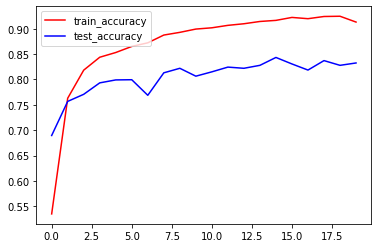

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(history_dict["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history_dict["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

7. Do the same for your `loss`

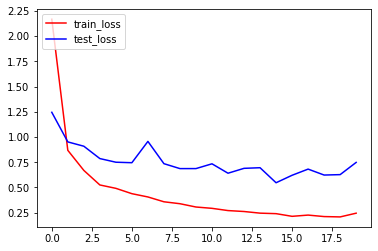

In [ ]:
# Visualise train / Valid Loss
plt.plot(history_dict["loss"], c="r", label="train_loss")
plt.plot(history_dict["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, classification_report


In [ ]:
img_generator_flow_train #sortir le label et le convertir en numpy

In [ ]:
y_true=img_generator_flow_train.labels   #y_true=y_train
print(y_true)
len(y_true)

[0 0 0 ... 4 4 4]


6872

In [ ]:
y_pred = model.predict(img_generator_flow_train)

In [ ]:
y_pred_bin=[]
for i in range(len(y_pred)):  
  y_pred_bin.append(np.argmax(y_pred[i]))

In [ ]:
y_pred_bin

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred_bin)

print(cf_matrix)

[[ 75 112 257 309 239]
 [ 59  93 184 190 147]
 [143 271 532 529 372]
 [157 269 463 514 413]
 [133 247 409 416 339]]


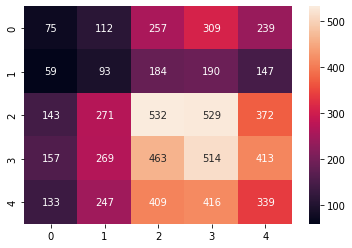

In [ ]:
ax = sns.heatmap(cf_matrix, fmt='d',annot=True)

In [ ]:
print(y_pred)
print(len(y_pred))

[[5.6659549e-01 4.3340215e-01 2.7631272e-11 2.1148987e-06 2.8779397e-07]
 [9.8932463e-01 3.6436317e-03 3.0319798e-09 1.9234851e-07 7.0314505e-03]
 [3.1041423e-06 5.1557601e-07 3.3894372e-05 1.7804788e-01 8.2191455e-01]
 ...
 [8.7591470e-04 5.2145404e-01 1.7765266e-05 4.7759721e-01 5.5022236e-05]
 [7.3022511e-06 2.2119933e-05 9.9996650e-01 4.0647378e-06 1.6183975e-08]
 [1.8148473e-10 1.8812425e-09 2.0680999e-13 2.6248374e-08 1.0000000e+00]]
6872


In [ ]:
f1_score_train=f1_score(y_true,y_pred_bin,average='macro')   #train
f1_score_train

0.19810237668172045

In [ ]:
y_pred_maj=[3 for i in range (len(y_true))]
f1_score_train_maj=f1_score(y_true,y_pred_maj,average='macro')   #train
f1_score_train_maj

0.08360957642725599

In [ ]:
y_pred_maj

In [ ]:
y_true_valid=img_generator_flow_valid.labels

In [ ]:
y_pred_valid = model.predict(img_generator_flow_valid)

In [ ]:
y_pred_valid_bin=[]
for i in range(len(y_pred_valid)):  
  y_pred_valid_bin.append(np.argmax(y_pred_valid[i]))

In [ ]:
f1_score(y_true_valid, y_pred_valid_bin,average='macro') #test

0.19021841779504545

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_true_valid, y_pred_valid_bin)

print(cf_matrix)

[[ 13  30  69  90  45]
 [ 11  22  35  56  44]
 [ 24  65 113 158 101]
 [ 32  46 106 160 110]
 [ 18  48 103 139  77]]


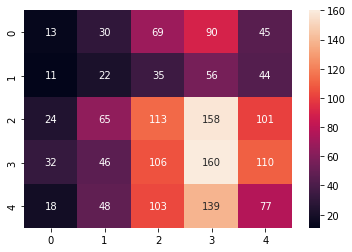

In [ ]:
ax = sns.heatmap(cf_matrix, fmt='d',annot=True)